In [1]:
from spring_mass import TweezedParticle
from kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from tqdm import tqdm

In [17]:
system = TweezedParticle(75e-3, pressure=1e-5, omega=1119991.718)

In [3]:
N_times=int(1e6)
t = np.linspace(0, 0.008976045381275687, N_times)
delta_t = np.diff(t)[0]
kb=1.38064852e-11                # Boltzmann cst.          picoJoule/Kelvin

In [4]:
sigma_processes = np.sqrt(2*kb*system._gamma_*system.T*delta_t)/system._m_
sigma_processes**2

0.05980781925044118

In [5]:
def dLQR(A, B, Q, R, x, xf,dt=0.1):
    """
    Discrete-time linear quadratic regulator for a non-linear system.
 
    Compute the optimal control given a nonlinear system, cost matrices, 
    a current state, and a final state.
    Compute the control variables that minimize the cumulative cost.
 
    Solve for P using the dynamic programming method.
 
    Assume that Qf = Q
 
    Input:
      :param F: The dynamics class object (has forward and linearize functions 
                implemented)
      :param Q: The state cost matrix Q -> np.array with shape (3,3)
      :param R: The input cost matrix R -> np.array with shape (2,2)
      :param x: The current state of the system x -> np.array with shape (2,)
      :param xf: The desired state of the system xf -> np.array with shape (2,)
      :param dt: The size of the timestep -> float
 
    Output
      :return: u_t_star: Optimal action u for the current state 
                   [linear velocity of the car, angular velocity of the car]
                   [meters per second, radians per second]
    """
    # We want the system to stabilize at xf, 
    # so we let x - xf be the state.
    # Actual state - desired state
    x_error = x - xf
    # Calculate the A and B matrices 
    # Solutions to discrete LQR problems are obtained using dynamic 
    # programming.
    # The optimal solution is obtained recursively, starting at the last 
    # time step and working backwards.
    N = 50
 
    # Create a list of N + 1 elements
    P = [None] * (N + 1)
 
    # Assume Qf = Q
    Qf = Q
 
    # 1. LQR via Dynamic Programming 
    P[N] = Qf 
 
    # 2. For t = N, ..., 1
    for t in range(N, 0, -1):
 
      # Discrete-time Algebraic Riccati equation to calculate the optimal 
      # state cost matrix
      P[t-1] = Q + A.T @ P[t] @ A - (A.T @ P[t] @ B) @ la.pinv(
               R + B.T @ P[t] @ B) @ (B.T @ P[t] @ A)      
#    print(P)
    # Create a list of N elements
    K = [None] * N
    u = [None] * N
 
    # 3 and 4. For t = 0, ..., N - 1
    for t in range(N):
 
      # Calculate the optimal feedback gain K_t
      K[t] = -la.pinv(R + B.T @ P[t+1] @ B) @ B.T @ P[t+1] @ A
 
    for t in range(N):
     
      # Calculate the optimal control input
      u[t] = K[t] @ x_error
 
    # Optimal control input is u_t_star
    u_t_star = u[N-1]
   
    # Return the optimal control inputs
    return u_t_star
 
def get_R():
    """
    This function provides the R matrix to the lqr_ekf_control simulator.
     
    Returns the input cost matrix R.
 
    Experiment with different gains.
    This matrix penalizes actuator effort 
    (i.e. rotation of the motors on the wheels).
    The R matrix has the same number of rows as are actuator states 
    [linear velocity of the car, angular velocity of the car]
    [meters per second, radians per second]
    This matrix often has positive values along the diagonal.
    We can target actuator states where we want low actuator 
    effort by making the corresponding value of R large.   
 
    Output
      :return: R: Input cost matrix
    """
    R = np.array([[0.0001]]) # Penalization for angular velocity effort

    return R
 
def get_Q():
    """
    This function provides the Q matrix to the lqr_ekf_control simulator.
     
    Returns the state cost matrix Q.
 
    Experiment with different gains to see their effect on the vehicle's 
    behavior.
    Q helps us weight the relative importance of each state in the state 
    vector (X, Y, THETA). 
    Q is a square matrix that has the same number of rows as there are states.
    Q penalizes bad performance.
    Q has positive values along the diagonal and zeros elsewhere.
    Q enables us to target states where we want low error by making the 
    corresponding value of Q large.
    We can start with the identity matrix and tweak the values through trial 
    and error.
 
    Output
      :return: Q: State cost matrix (3x3 matrix because the state vector is 
                  (X, Y, THETA))
    """
    Q = np.array([[10, 0], # Penalize X position error (global coordinates)
                  [0, 1000]])# Penalize heading error (global coordinates)
     
    return Q

In [6]:
system.B

array([[  0.        ],
       [102.88804402]])

In [55]:
xs, xs_noise, vs = [], [], []
x = 1e-3
v = 0
std_detection = 1e-3
A=np.matrix([[1,delta_t],[-system._k_*delta_t, 1-system._gamma_*delta_t]])
B=np.matrix([[0],[delta_t]])##ix([[0],[delta_t]])
C=np.matrix([[1, 0]])
R=np.array([[np.power(std_detection,2)]])
Q = np.array([[0, 0], [0, sigma_processes**2]])

x0=np.matrix([[0],[0]])
P0=1*np.matrix(np.eye(2))
kalman = KalmanFilter(x0,P0,A,B,C,Q,R)
inputValue=np.matrix([[0]])
position_estimation, velocity_estimation = [], []
control_v = 0
N=100000
for i in tqdm(range(N)):
    xs.append(x)
    vs.append(v)
    #control = dLQR(A, system.B, get_Q(), get_R(), np.array([[x],[v]]), np.array([[0],[0]]), dt=delta_t)[0,0]
#    print(control)
#    x, v = system.step(np.array([[x],[v]]), delta_t=delta_t, control=control[0,0])
    control=-1000*x-1000*v
    control=0
#    print(control, x)
    x, v = system.step(np.array([[x], [v]]), delta_t=delta_t, control=control)
    x_noise = x+std_detection*np.random.normal()
    xs_noise.append(x_noise) 
#    kalman.propagateDynamics(np.array([[control]]))
#    kalman.computeAposterioriEstimate(x_noise)
#    position_estimation.append(kalman.estimates_aposteriori[i][0,0])
#    velocity_estimation.append(kalman.estimates_aposteriori[i][1,0])
#    control_v = kalman.estimates_aposteriori[i][1,0]
xs, vs = np.array(xs), np.array(vs)

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 57459.80it/s]


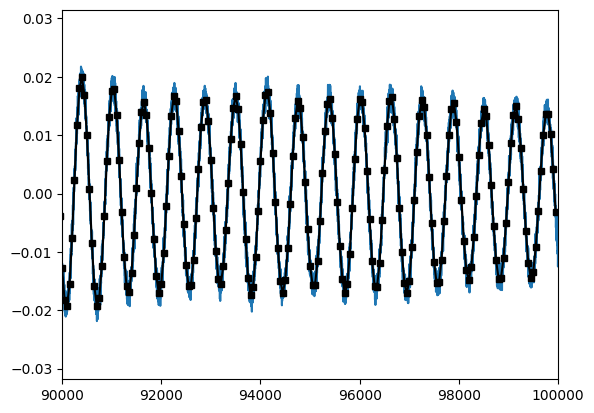

In [56]:
plt.plot(xs_noise)
plt.plot(np.arange(0,N,1)[::50],xs[::50], marker='s', color='black', markersize=5)
plt.plot(position_estimation, color='orange')
#plt.ylim([-0.01,0.01])
plt.xlim([90000,100000])
plt.show()

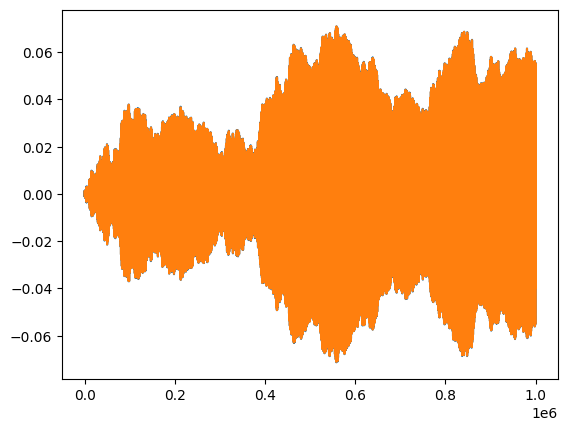

array([ 0.001     ,  0.0009998 ,  0.00099881, ..., -0.03885157,
       -0.03924773, -0.03963955])

In [167]:
plt.plot(xs_noise)
plt.plot(xs)
#plt.xlim([0,8000])
plt.show()
xs

In [169]:
estimate1=[]
estimate2=[]
for j in range(64000):
    estimate1.append(KalmanFilterObject.estimates_aposteriori[j][0,0])
    estimate2.append(KalmanFilterObject.estimates_aposteriori[j][1,0])

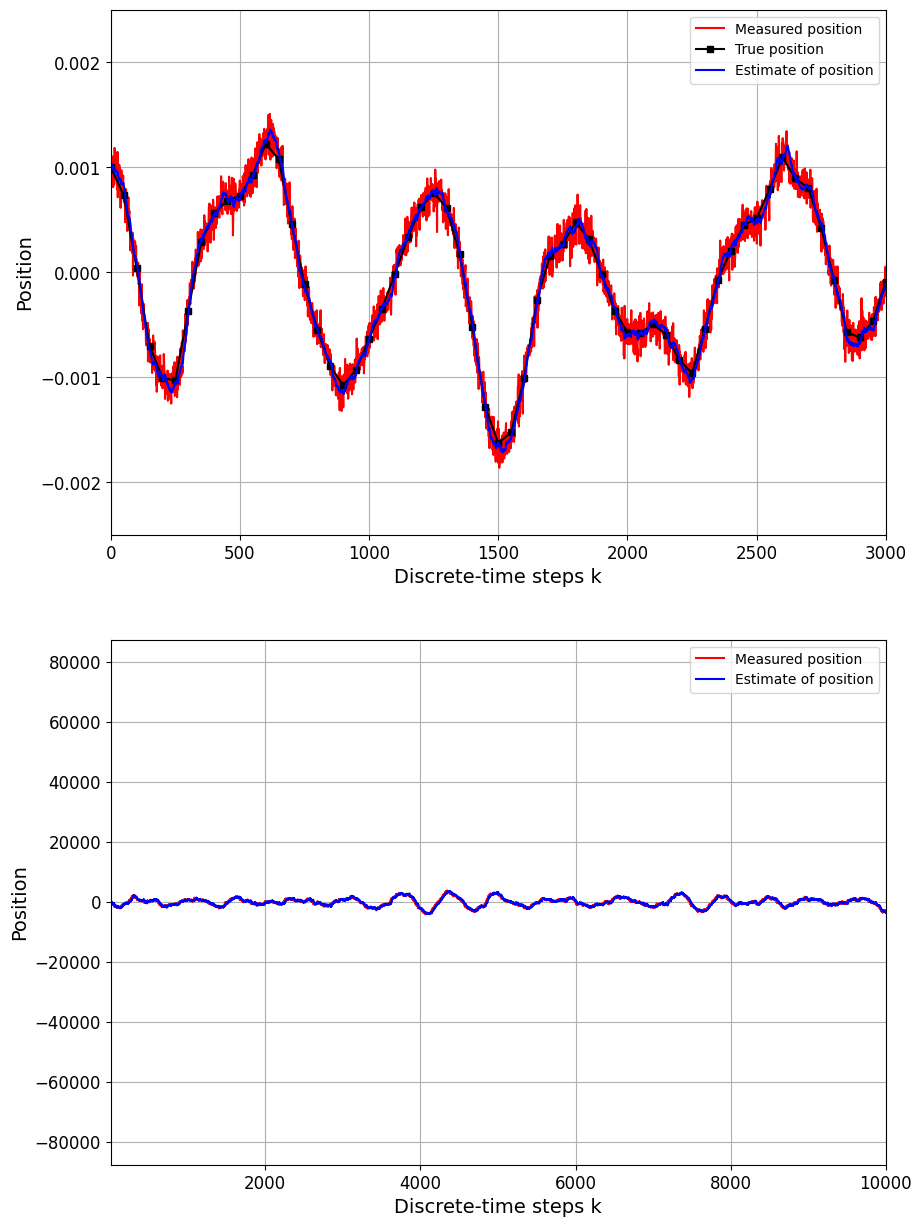

In [170]:
#steps=np.arange(np.size(timeVector))
fig, ax = plt.subplots(2,1,figsize=(10,15))

ax[0].plot(xs_noise,color='red',linestyle='-',label='Measured position')
ax[0].plot(np.arange(0,8000,1)[::50],xs[:8000][::50],color='black', marker='s', markersize=5, linestyle='-',label='True position')
ax[0].plot(estimate1,color='blue',linestyle='-',label='Estimate of position')

ax[0].set_xlim([0, 3000])
ax[0].set_ylim([-0.0025,0.0025])
ax[0].set_xlabel("Discrete-time steps k",fontsize=14)
ax[0].set_ylabel("Position",fontsize=14)
ax[0].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(fontsize=10)
 

#ax[0].plot(np.arange(0,8000,1)[::20],xs[:8000][::20],color='black', marker='s', markersize=5, linestyle='-',label='True position')
ax[1].plot(vs,color='red',linestyle='-',label='Measured position')
ax[1].plot(estimate2,color='blue',linestyle='-',label='Estimate of position')
ax[1].set_xlim([8, 10000])
#ax[1].set_ylim([-0.06,0.06])
ax[1].set_xlabel("Discrete-time steps k",fontsize=14)
ax[1].set_ylabel("Position",fontsize=14)
ax[1].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[0].set_ylim(98,102)  
ax[1].grid()
ax[1].legend(fontsize=10)


In [116]:

np.arange(0,8000,1)

array([   0,    1,    2, ..., 7997, 7998, 7999])

In [43]:
hbar=1.05457e-34

In [8]:
xzp=np.sqrt(hbar/(2*system._m_*system._omega_))

In [9]:
xzp

3.4799080018717364e-12